# (Markov Chain) Monte Carlo
Monte Carlo simulations are a family of stochastic methods used to for sampling. Today, we will be focused on Markov Chain Monte Carlo. 
Agenda today:
- Review on Bayesian statistics
- Markov Chain Monte Carlos 
    - Markov Property 
    - Monte Carlo Simulation 
- MCMC variations
    - Metropolis Algorithm 
    - Gibbs Sampling 
___
- _adapted from chapter of the [Statistical Rethinking]() by Richard McElreath_ <br>
- _Shoutout to Ben Shaver for his awesome [blog post](https://towardsdatascience.com/a-zero-math-introduction-to-markov-chain-monte-carlo-methods-dcba889e0c50) for the intuitive idea_ <br>
- _graph credit to Stanford Stats 305_
___

## Part I. Review of Bayesian Statistics 
- Prior
- Evidence 
- Posterior

In [11]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Text(0, 0.5, 'Probability')

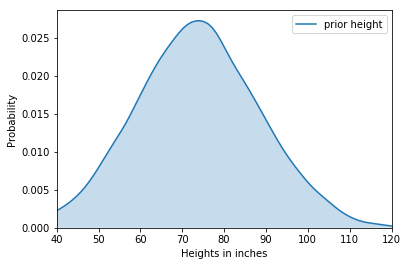

In [2]:
# simulate a prior distribution with human heights - where a person believes that the average height for humans are 6'2
mu1, sigma1 = 74, 15 # mean and standard deviation
s1 = list(np.random.normal(mu1, sigma1, 10000))
sns.kdeplot(s1, shade=True, label="prior height")
plt.xlim(40,120)
plt.xlabel('Heights in inches')
plt.ylabel('Probability')


Text(0, 0.5, 'Probability')

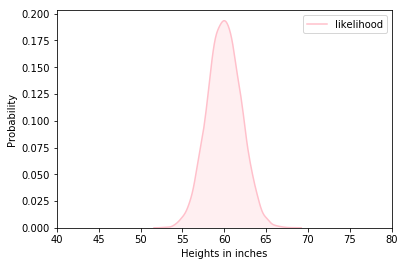

In [3]:
# simulate evidence - the data this person collected
mu2, sigma2 = 60, 2 # mean and standard deviation
s2 = list(np.random.normal(mu2, sigma2, 10000))
sns.kdeplot(s2, shade=True, label="likelihood", color = 'pink')
plt.xlim(40,80)
plt.xlabel('Heights in inches')
plt.ylabel('Probability')

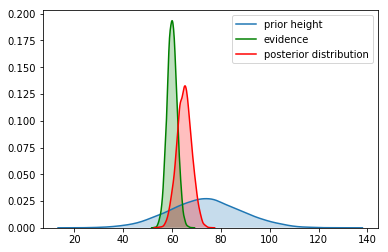

In [4]:
# for a Bayesian practitioner, we get to incorporate our prior belief and evidence and compute posterior distribution 
sns.kdeplot(s1, shade=True, label="prior height")
sns.kdeplot(s2, shade=True, label="evidence", color = 'green')
s3 = list(np.random.normal(65, 3, 10000))
sns.kdeplot(s3, shade=True, label="posterior distribution", color = 'red')

This - the posterior distribution - tells us which parameter values maximize the chance of observing the particular data that we did, taking into account our prior beliefs.

In the case of normal distributions, solving for posterior is computationally simple. However, if the shape of our prior or likelihood are complicated, then it is harder to compute the posterior distribution. Thus we need a method to help us **simulate** in a stochastic manner such that we can draw from the posterior even when we cannot compute it directly. How, does MCMC determine the value or shape of our posterior distribution when computing it analytically is difficult? Before diving into that, we shall familiarize ourselves with the concept of MCMC.

____
## Part II. Markov Chain Monte Carlo
#### 2.1 Monte Carlo

Two major components of MCMC are the Monte Carlo method and Markov Chain property. Let's start by talking about Monte Carlo simulation. Monte Carlo simulation can be used for estimating a parameter by randomly simulating values repeatedly, and assessing the impact of risk and uncertainty in financial setting. 
For example:
- if we want to estimate the area of a circle, we can randomly drop points on a the square. We can estimate the area of the circle by computing the proportion of the points in the circle versus outside of the circle.
- if we want to assess what is the long term probability of profitting from betting at a casino given the house edge

Today, we will learn how Monte Carlo Simulation can help us understand parameters that are hard to estimate directly.

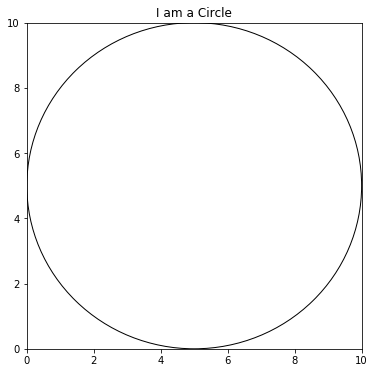

In [5]:
fig = plt.figure(figsize=(6,6))
axis = fig.add_subplot(1,1,1)
circle = plt.Circle((5,5), 5, fill = False)
axis.add_patch(circle)
axis.set_xlim([0,10])
axis.set_ylim([0,10])
axis.set_title('I am a Circle')
plt.show()

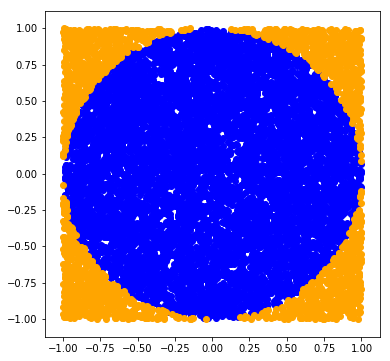

In [16]:
n_points = 10000
x = np.random.uniform(low=-1, high=1, size=n_points)
y = np.random.uniform(low=-1, high=1, size=n_points)

inside = {'x':[], 'y':[]}
outside = {'x':[], 'y':[]}

#2 Determine if the point is inside or outside our circle
count = 0
for x, y in list(zip(x,y)):
    if x**2 + y**2 <= 1:
        inside['x'] = inside['x'] + [x]
        inside['y'] = inside['y'] + [y]
    else:
        outside['x'] = outside['x']  + [x]
        outside['y'] = outside['y']  + [y]
    
#3 Use these sample points to estimate our circle area
plt.figure(figsize = (6,6))
circle = plt.Circle((5,5), 5, fill = False)
axis.add_patch(circle)
axis.set_xlim([0,10])
axis.set_ylim([0,10])
axis.set_title('I am a Circle')
plt.scatter(inside['x'], inside['y'], c='blue')
plt.scatter(outside['x'], outside['y'], c='orange')
plt.show()

When the random values generated by stochastic methods are high enough, we will eventually approximate the area of the circle. We can use this method to estimate the area of a complex shape that necessitates complex formula -- for the batman shape, we can also approximate the area by randomly dropping points in there and calculate the proportion of the points inside the shape versus other of it. 

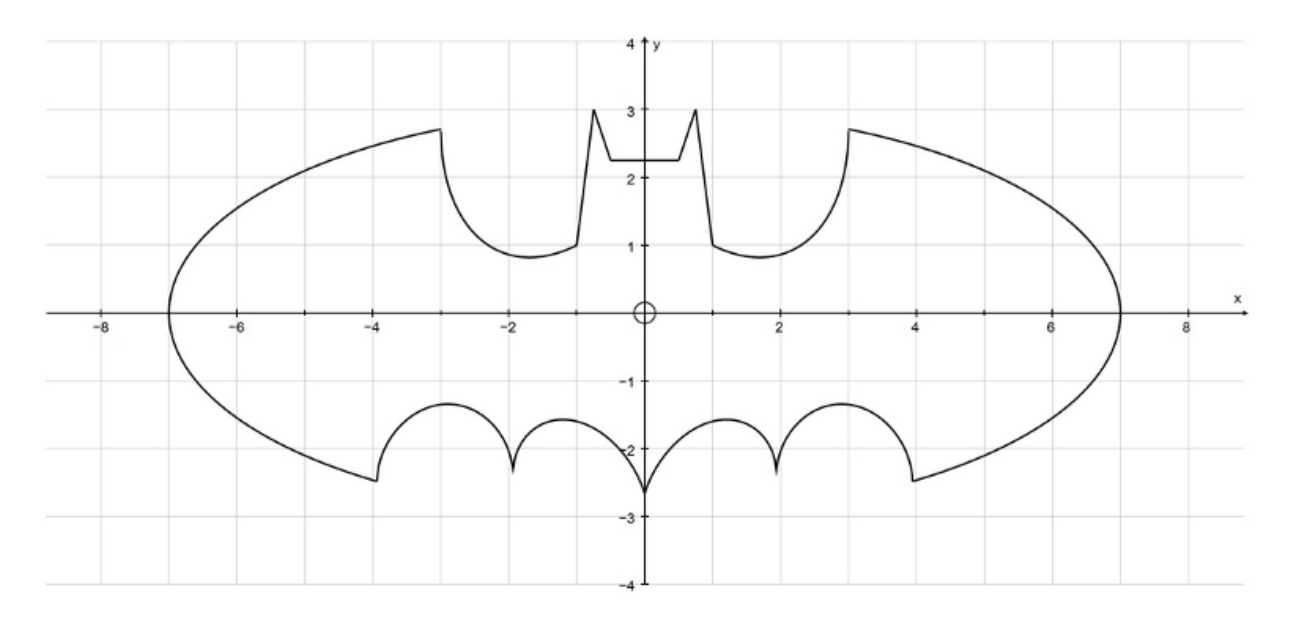 <br>


#### 2.2 Markov Chain 
The second part of the MCMC algorithm is the Markov Chain property. Markov property refers to the memoryless nature of conditional processes. Mathematician (Audrey Markov) has showed that even though certain processes seem random, they eventually settle into a pattern. Therefore, Markov Chain refers to random processes in which the future events only depend on the immediate previous step, but not the steps preceding that. 

Question - How does graph theory relate to Markov Chain Monte Carlo?

Going back to the example of human heights above - using MCMC, we can effectively estimate the parameter of posterior distributin of human heights by _sampling_ from the posterior distribution, and compute on the samples we have drawn from the posterior distribution. The simulation will pick a pair of random parameters to evaluate, how compute how likely the parameter value is to generate the data (what does this remind you of?) given our prior, and add new values to a chain of previously sampled values. 

## 3. Types of MCMC

#### 3.1 Metropolis Algorithm 
King Markov's island kingdom. 
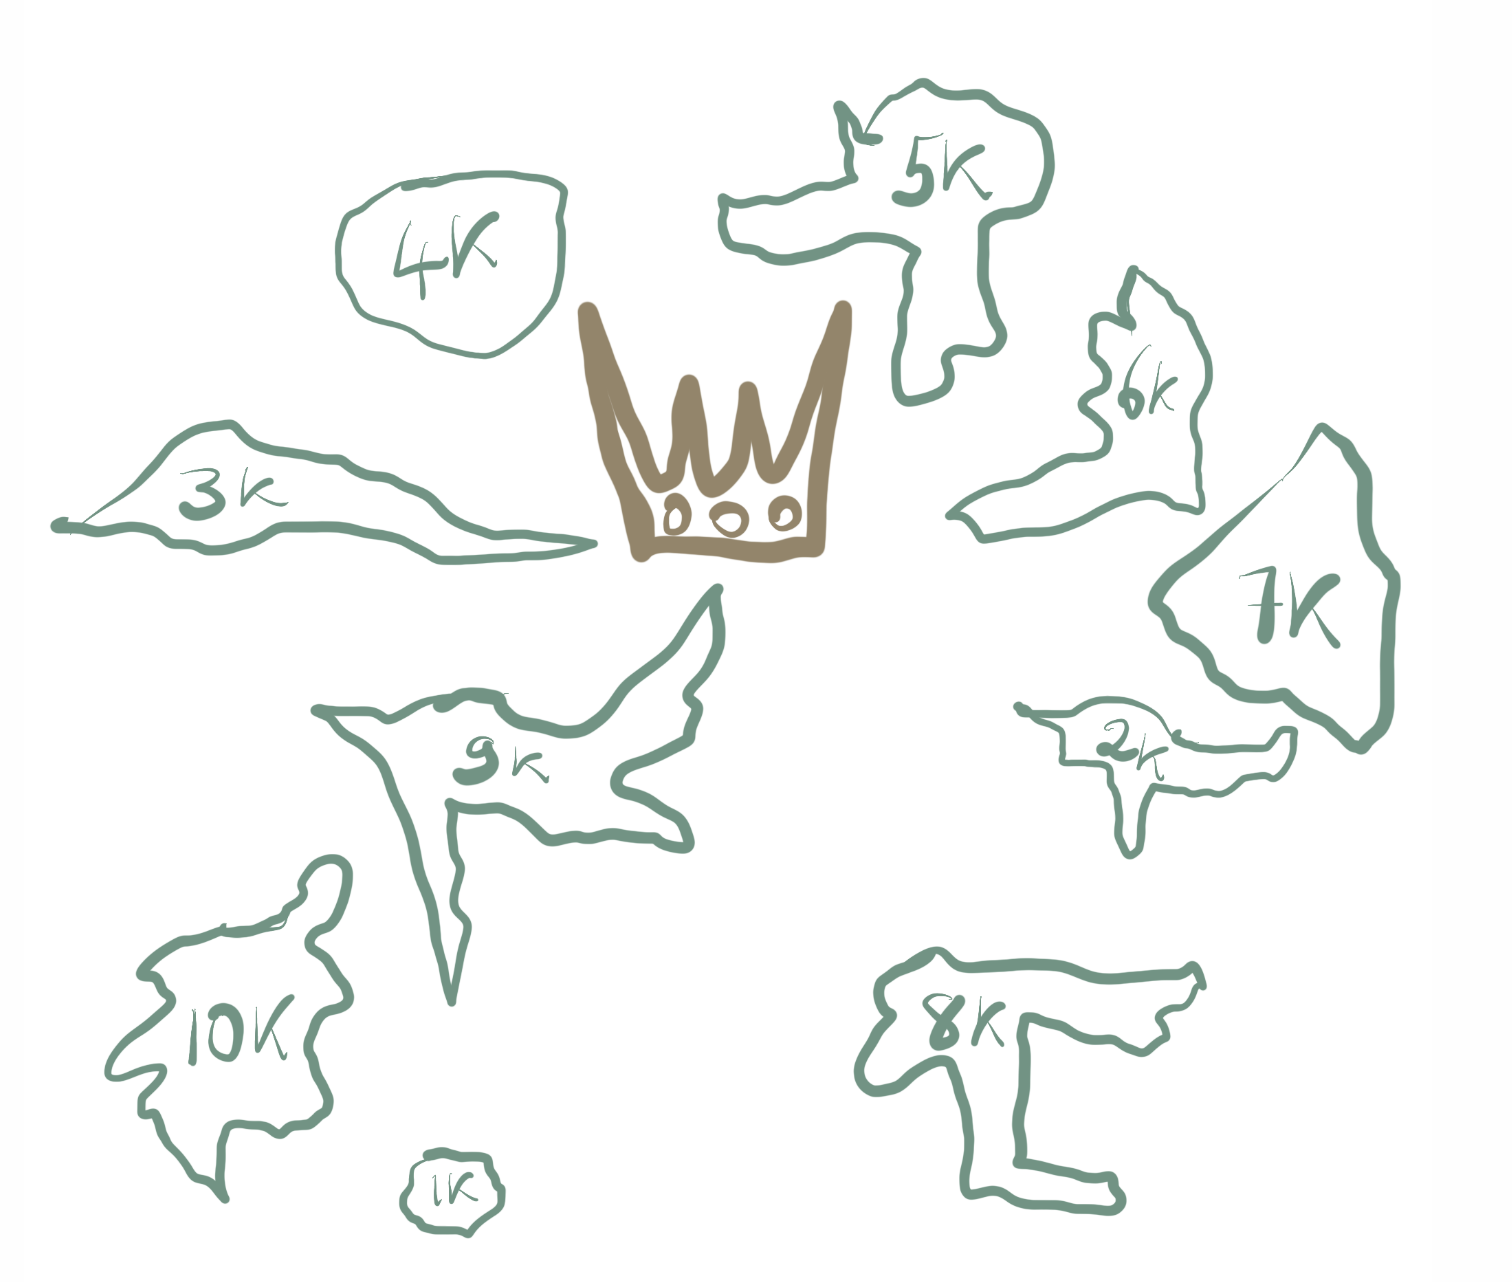


Set up: King Markov is the benevolent autocratic king who visists 10 of his islands. The size of each island corresponds to the population on that island: for example, the first island has 1000 people, and the second island that's twice as big has 2000 people etc. His goal is to schedule his visit in such a way that he stays the amount of time corresponding to the population size. He is not one to keep a stringent schedule, so he resorts to Metropolis for advice on scheduling. Metropolis proposed the _metropolis algorithm_ for keeping track of his schedule:
1. Wherever the king is, he decides whether to stay put for a week or move to one of the two neigboring islands;
2. He flips a coin and decides where to move next;
3. If he gets heads, he consider moving to the island clockwise; otherwise he consider moving counterclockwise. Let's call the island the coin nominates **the proposal island**;
4. To decide whether to move to the proposal island, he counts the number of seashells corresponding to the population size of the proposal island. Then he also counts out a number of stones equal to the relative population of the current island 
5. When the number of seashells are larger than the number of stones, he moves to the proposal island; but if seashells are less than stones, he discard the number of stones equal to the number of seashells. For example, if he has 4 shells and 6 stones, he throws away 6 - 4 = 2 stones and 4 shells
6. He then places the seashell and the stones in a bag and randomly select an object. If it is a shell, he moves to the proposal island; otherwise he stays put for another week. 

__As it turns out, in the long run, the procedure guarantees that the king will be found on each island proportionate to its population size__

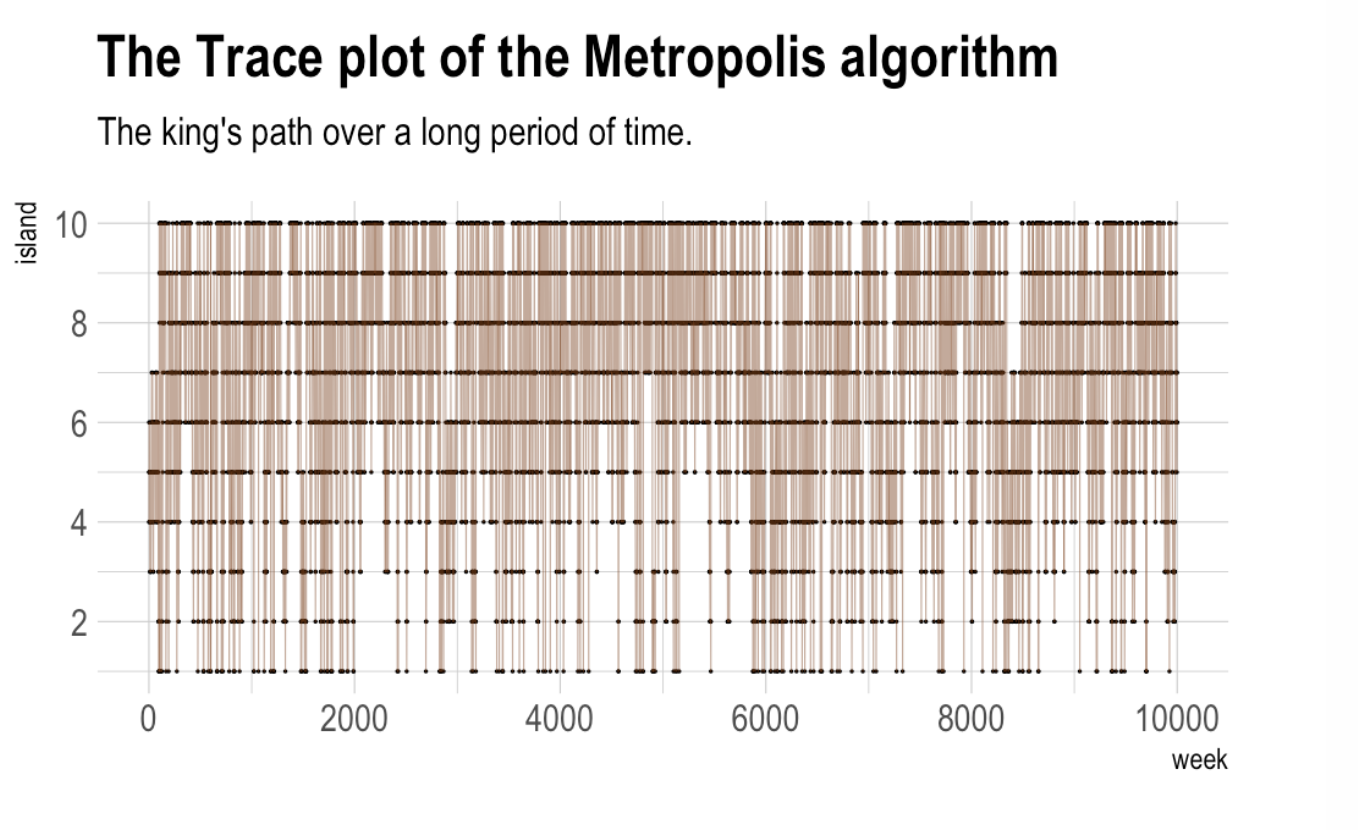 <br>

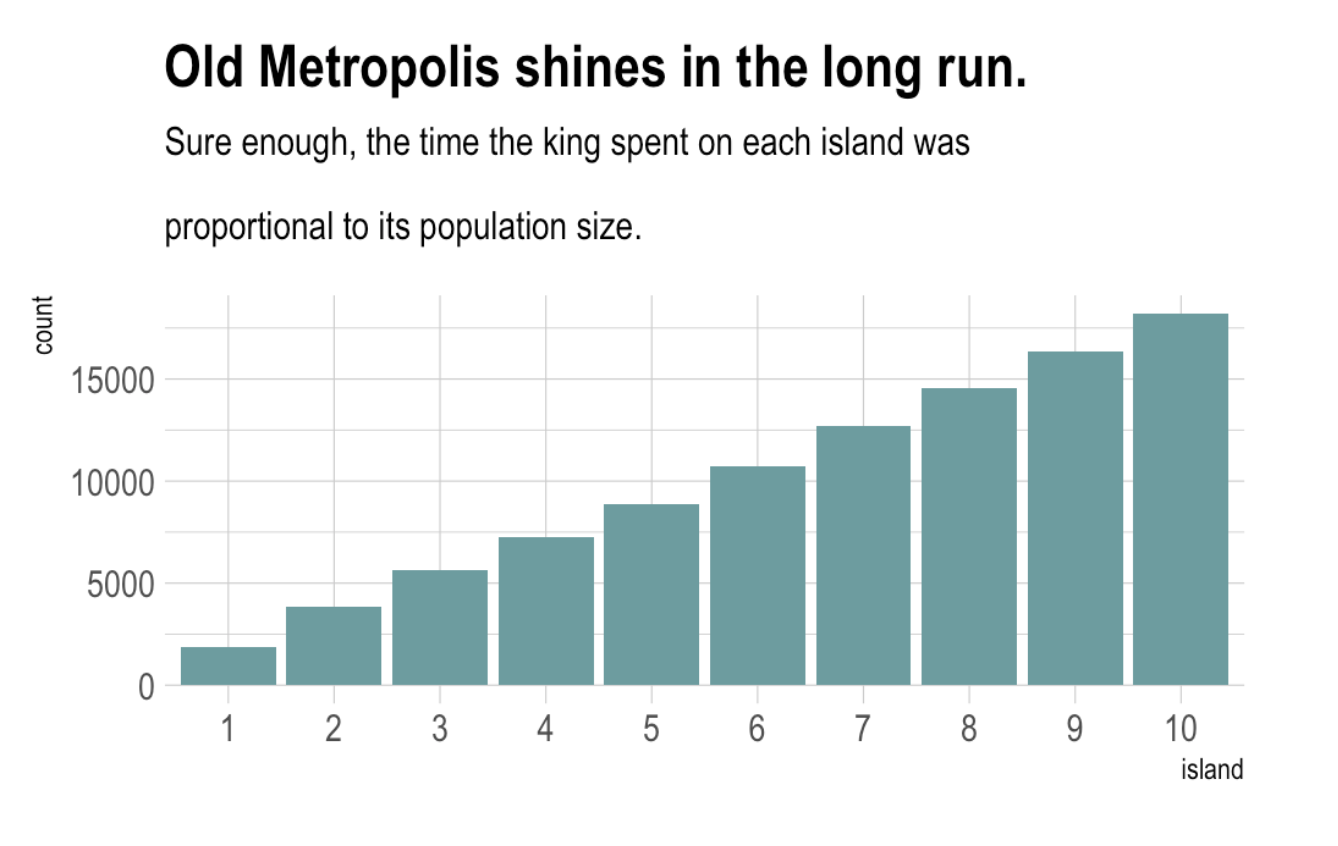 <br>


How does this case applies to theoretical aspect of MCMC?
- The "island" in our objective are parameter values
- The "population size" is the posterior distribution
- The "weeks" are samples taken from the joint posterior of the parameter in the model 

#### 3.2 Gibbs Sampling 
The algorithm described above is a particular case of Metropolis algorithm in which the proposal is symmetrical (equally likely to have heads and tails). The more general form of this type of MCMC is called Metropolis-Hastings algorithm, which handles asymmetric proposal (coin is biased and might be more likely to lead him to heads or tails).
<br>

Another important variation of MCMC is Gibbs sampling, which is computes and samples adapatively. Gibbs sampling uses particular combination of likelihood distribution and prior distribution known as _conjugate pairs_.

### Returning to previous point - how do you estimate posterior distribution using MCMC?
What we know is our posterior distribution is somewhere in between our prior and evidence distribution, so we can effectively randomly draw samples from it, and compute statistics from the sample drawn. To begin, MCMC methods pick a random parameter value to consider. The simulation will continue to generate random values (this is the Monte Carlo part), but subject to some rule for determining what makes a good parameter value. The trick is that, for a pair of parameter values, it is possible to compute which is a better parameter value, by computing how likely each value is to explain the data, given our prior beliefs. If a randomly generated parameter value is better than the last one, it is added to the chain of parameter values with a certain probability determined by how much better it is (this is the Markov chain part).

After a period of time of sampling, since the random samples are subject to fixed probabilities, they tend to converge after a period of time in the region of the highest probabilities for the parameter mean height. We can then output a probability distribution, which serves as our **best guess** for the true shape of the posterior distribution.